# Evaluation Pipeline

This notebook evaluates the trained models (RGB and RGBD) on the test set.

Features:
- RGB Pipeline: Full 6D pose (rotation + translation) evaluation
- RGBD Pipeline: DenseFusion, PVN3D, FFB6D, Residual Learning evaluation
- Unified dataset loader with YOLO detection

In [1]:
import os
import sys
import platform
import importlib
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Add project root to path
project_root = os.path.dirname(os.getcwd())
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Force reload utils.dataset to pick up RGB->BGR fix
import utils.dataset
importlib.reload(utils.dataset)

# Imports (after reload)
from rgb_pipeline.config import ConfigRGB, ConfigInference
from rgb_pipeline.model import RGBPoseEstimator
from rgb_pipeline.train import compute_pinhole_translations
from rgbd_pipelines import create_model, list_models
from rgbd_pipelines.evaluate import evaluate_model as evaluate_rgbd_model
from utils.dataset import LineMODDataset, linemod_collate_fn, rgbd_collate_fn
from utils.geometry import quaternion_to_rotation_matrix
from utils.metrics import average_distance_metric
from utils import load_ply_vertices

print(f"Platform: {platform.system()} {platform.release()}")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
print("[OK] utils.dataset reloaded with RGB->BGR fix")

Platform: Linux 6.6.87.2-microsoft-standard-WSL2
PyTorch: 2.9.1+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 5070
[OK] utils.dataset reloaded with RGB->BGR fix


In [2]:
# ==============================================================================
# EVALUATION FUNCTIONS
# ==============================================================================

def compute_rotation_error(pred_quaternion, gt_rotation_matrix):
    """
    Compute rotation error between predicted quaternion and GT rotation matrix.
    
    Args:
        pred_quaternion: Predicted quaternion [4] (w, x, y, z)
        gt_rotation_matrix: GT rotation matrix [3, 3]
    
    Returns:
        error_degrees: Angular error in DEGREES
    """
    pred_rot_matrix = quaternion_to_rotation_matrix(pred_quaternion)
    R_error = pred_rot_matrix.T @ gt_rotation_matrix
    trace = np.trace(R_error)
    cos_theta = np.clip((trace - 1.0) / 2.0, -1.0, 1.0)
    theta = np.arccos(cos_theta)
    return np.degrees(theta)


def compute_translation_error(pred_translation, gt_translation):
    """
    Compute L2 error between predicted and GT translation.
    
    Args:
        pred_translation: Predicted translation [3] in METERS
        gt_translation: GT translation [3] in METERS
    
    Returns:
        error: Translation error in METERS
    """
    return np.linalg.norm(np.array(pred_translation) - np.array(gt_translation))


def pose_to_matrix(quaternion, translation):
    """Convert quaternion + translation to 4x4 pose matrix."""
    R = quaternion_to_rotation_matrix(quaternion)
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = translation
    return T


def compute_bbox_iou(bbox_pred, bbox_gt):
    """
    Compute Intersection over Union (IoU) between two bounding boxes.
    
    Both bboxes must be in (x1, y1, x2, y2) format.
    
    Args:
        bbox_pred: Predicted bbox (x1, y1, x2, y2)
        bbox_gt: Ground truth bbox (x1, y1, x2, y2)
    
    Returns:
        iou: Intersection over Union value [0, 1]
    """
    # Extract coordinates
    x1_pred, y1_pred, x2_pred, y2_pred = bbox_pred
    x1_gt, y1_gt, x2_gt, y2_gt = bbox_gt
    
    # Compute intersection
    x1_inter = max(x1_pred, x1_gt)
    y1_inter = max(y1_pred, y1_gt)
    x2_inter = min(x2_pred, x2_gt)
    y2_inter = min(y2_pred, y2_gt)
    
    # Compute intersection area
    inter_width = max(0, x2_inter - x1_inter)
    inter_height = max(0, y2_inter - y1_inter)
    inter_area = inter_width * inter_height
    
    # Compute union area
    pred_area = max(0, x2_pred - x1_pred) * max(0, y2_pred - y1_pred)
    gt_area = max(0, x2_gt - x1_gt) * max(0, y2_gt - y1_gt)
    union_area = pred_area + gt_area - inter_area
    
    # Compute IoU
    if union_area > 0:
        iou = inter_area / union_area
    else:
        iou = 0.0
    
    return iou


def compute_geometric_anchor_batch(batch, device):
    """
    Compute geometric anchor (T_geo) for residual_learning model.
    
    CRITICAL: This function computes the proper geometric anchor using
    bounding box, depth, and intrinsics. Using point cloud centroid as T_geo
    is INCORRECT and causes ~4cm error.
    
    Args:
        batch: Batch dictionary with bbox_abs, depth_crop, intrinsics, crop_offset
        device: Target device
        
    Returns:
        T_geo: Geometric anchor [B, 3] in METERS
    """
    from rgbd_pipelines.residual_learning.geometric_anchor import get_geometric_anchor_batch
    
    T_geo = get_geometric_anchor_batch(
        bboxes=batch['bbox_abs'],
        depth_crops=batch['depth_crop'],
        intrinsics=batch['intrinsics'],
        crop_offsets=batch['crop_offset'],
        shrink_factor=0.15,
        depth_percentile=20.0
    )
    
    return T_geo.to(device)


@torch.no_grad()
def evaluate_rgb_model(model, dataloader, device, object_name, model_points=None, add_threshold=0.1):
    """
    Evaluate RGB model on test set.
    
    The RGB model predicts BOTH rotation and translation from:
    - RGB crop
    - Pinhole translation estimate (as input)
    
    UNIT CONVENTIONS:
    - Input translations: METERS
    - Output trans_err: CENTIMETERS (for readability)
    - Rotation errors: DEGREES
    
    Args:
        model: RGBPoseEstimator model
        dataloader: Test DataLoader
        device: Compute device
        object_name: LineMOD object name (for pinhole translation)
        model_points: 3D model points for ADD metric (optional)
        add_threshold: ADD success threshold (default 10% of diameter)
    
    Returns:
        Dictionary with evaluation metrics
    """
    model.eval()
    
    rotation_errors = []
    translation_errors = []  # Will store errors in CENTIMETERS
    add_distances = []
    add_successes = []
    
    for batch in dataloader:
        images = batch['rgb'].to(device)
        gt_rot_matrix = batch['rotation'].numpy()
        gt_trans = batch['translation'].numpy()  # GT translation in METERS
        bboxes = batch['bbox']
        
        # Compute pinhole translation (input to network) - in METERS
        pinhole_trans = compute_pinhole_translations(bboxes, object_name).to(device)
        
        # Forward pass: model predicts rotation AND translation
        pred_rot, pred_trans = model(images, pinhole_trans)
        
        pred_rot = pred_rot.cpu().numpy()
        pred_trans = pred_trans.cpu().numpy()  # Prediction in METERS
        
        # Compute metrics for each sample in batch
        for i in range(len(images)):
            # Rotation error (DEGREES)
            rot_err = compute_rotation_error(pred_rot[i], gt_rot_matrix[i])
            rotation_errors.append(rot_err)
            
            # Translation error: computed in METERS, stored in CENTIMETERS
            trans_err_meters = compute_translation_error(pred_trans[i], gt_trans[i])
            trans_err_cm = trans_err_meters * 100  # Convert METERS -> CENTIMETERS
            translation_errors.append(trans_err_cm)
            
            # ADD metric (if model points available)
            if model_points is not None:
                pred_pose = pose_to_matrix(pred_rot[i], pred_trans[i])
                gt_pose = np.eye(4)
                gt_pose[:3, :3] = gt_rot_matrix[i]
                gt_pose[:3, 3] = gt_trans[i]
                
                add_dist, success = average_distance_metric(
                    pred_pose, gt_pose, model_points, add_threshold
                )
                add_distances.append(add_dist)
                add_successes.append(success)
    
    # Note: translation_errors are already in CENTIMETERS
    results = {
        'rot_err_mean': np.mean(rotation_errors),
        'rot_err_median': np.median(rotation_errors),
        'rot_err_std': np.std(rotation_errors),
        'trans_err_mean': np.mean(translation_errors),  # in CENTIMETERS
        'trans_err_median': np.median(translation_errors),  # in CENTIMETERS
        'trans_err_std': np.std(translation_errors),
        'acc_5deg': np.mean(np.array(rotation_errors) < 5) * 100,
        'acc_10deg': np.mean(np.array(rotation_errors) < 10) * 100,
        'acc_5cm': np.mean(np.array(translation_errors) < 5) * 100,  # threshold in cm
        'acc_10cm': np.mean(np.array(translation_errors) < 10) * 100,  # threshold in cm
    }
    
    if add_distances:
        results['add_mean'] = np.mean(add_distances)
        results['add_success'] = np.mean(add_successes) * 100
    
    return results


@torch.no_grad()
def evaluate_yolo_iou(dataloader, device):
    """
    Compute YOLO detection IoU statistics.
    
    Compares YOLO-predicted bounding boxes against ground truth bboxes.
    Uses the 'yolo_detected' flag to distinguish real YOLO detections 
    from GT fallback (when YOLO fails to detect).
    
    IMPORTANT: IoU is only computed for REAL YOLO detections, not GT fallbacks.
    
    BBOX FORMATS:
    - bbox_abs from dataset: (x, y, w, h) - top-left corner + dimensions
    - bbox_gt from dataset: (x1, y1, x2, y2) - top-left and bottom-right corners
    
    Args:
        dataloader: Test DataLoader (must have 'bbox_abs', 'bbox_gt', 'yolo_detected')
        device: Compute device
        
    Returns:
        Dictionary with IoU statistics:
        - iou_mean: Mean IoU across REAL detections
        - iou_median: Median IoU
        - iou_std: Standard deviation of IoU
        - iou_50: Percentage of samples with IoU > 0.5
        - iou_75: Percentage of samples with IoU > 0.75
        - iou_90: Percentage of samples with IoU > 0.9
        - detection_rate: Percentage of frames where YOLO detected object
        - num_samples: Total number of samples
        - num_detected: Number of real YOLO detections
    """
    all_ious = []
    total_samples = 0
    real_detections = 0  # Only count REAL YOLO detections
    
    for batch in dataloader:
        # YOLO-predicted bbox: (x, y, w, h) format
        bboxes_pred = batch.get('bbox_abs')
        # Ground truth bbox: (x1, y1, x2, y2) format
        bboxes_gt = batch.get('bbox_gt')
        # Detection flag: True if YOLO detected, False if GT fallback
        yolo_detected = batch.get('yolo_detected')
        
        if bboxes_pred is None or bboxes_gt is None:
            continue
        
        # Convert to numpy if tensor
        if torch.is_tensor(bboxes_pred):
            bboxes_pred = bboxes_pred.numpy()
        if torch.is_tensor(bboxes_gt):
            bboxes_gt = bboxes_gt.numpy()
        if torch.is_tensor(yolo_detected):
            yolo_detected = yolo_detected.numpy()
        
        B = len(bboxes_pred)
        total_samples += B
        
        for i in range(B):
            bbox_pred_xywh = bboxes_pred[i]  # (x, y, w, h)
            bbox_gt_xyxy = bboxes_gt[i]  # (x1, y1, x2, y2)
            
            # Check if this is a REAL YOLO detection (not GT fallback)
            is_real_detection = yolo_detected[i] if yolo_detected is not None else True
            
            if is_real_detection:
                real_detections += 1
                
                # Convert bbox_pred from (x, y, w, h) to (x1, y1, x2, y2)
                x, y, w, h = bbox_pred_xywh
                bbox_pred_xyxy = (x, y, x + w, y + h)
                
                # Compute IoU (both in x1, y1, x2, y2 format)
                iou = compute_bbox_iou(bbox_pred_xyxy, bbox_gt_xyxy)
                all_ious.append(iou)
    
    if len(all_ious) == 0:
        return {
            'iou_mean': 0.0,
            'iou_median': 0.0,
            'iou_std': 0.0,
            'iou_50': 0.0,
            'iou_75': 0.0,
            'iou_90': 0.0,
            'detection_rate': 0.0,
            'num_samples': total_samples,
            'num_detected': 0
        }
    
    all_ious = np.array(all_ious)
    
    results = {
        'iou_mean': np.mean(all_ious),
        'iou_median': np.median(all_ious),
        'iou_std': np.std(all_ious),
        'iou_50': np.mean(all_ious > 0.5) * 100,  # % with IoU > 0.5
        'iou_75': np.mean(all_ious > 0.75) * 100,  # % with IoU > 0.75
        'iou_90': np.mean(all_ious > 0.9) * 100,  # % with IoU > 0.9
        'detection_rate': (real_detections / total_samples) * 100 if total_samples > 0 else 0.0,
        'num_samples': total_samples,
        'num_detected': real_detections
    }
    
    return results


def print_rgb_evaluation_report(results, object_name):
    """Print detailed evaluation report for RGB model."""
    print("\n" + "=" * 60)
    print(f"RGB EVALUATION RESULTS - {object_name.upper()}")
    print("=" * 60)
    
    print("\nROTATION ERROR")
    print(f"   Mean:   {results['rot_err_mean']:.2f} deg")
    print(f"   Median: {results['rot_err_median']:.2f} deg")
    print(f"   Std:    {results['rot_err_std']:.2f} deg")
    
    print("\nTRANSLATION ERROR")
    print(f"   Mean:   {results['trans_err_mean']:.2f} cm")
    print(f"   Median: {results['trans_err_median']:.2f} cm")
    print(f"   Std:    {results['trans_err_std']:.2f} cm")
    
    print("\nACCURACY")
    print(f"   < 5 deg:  {results['acc_5deg']:.1f}%")
    print(f"   < 10 deg: {results['acc_10deg']:.1f}%")
    print(f"   < 5cm:    {results['acc_5cm']:.1f}%")
    print(f"   < 10cm:   {results['acc_10cm']:.1f}%")
    
    if 'add_success' in results:
        print("\nADD METRIC")
        print(f"   Mean ADD:     {results['add_mean']:.4f} m")
        print(f"   Success Rate: {results['add_success']:.1f}%")
    
    print("\n" + "=" * 60)


def print_rgbd_evaluation_report(results, model_name, object_name):
    """Print detailed evaluation report for RGBD model."""
    print("\n" + "=" * 60)
    print(f"RGBD EVALUATION RESULTS - {model_name.upper()} on {object_name.upper()}")
    print("=" * 60)
    
    print("\nROTATION ERROR")
    print(f"   Mean:   {results['rot_err_mean']:.2f} deg")
    print(f"   Median: {results['rot_err_median']:.2f} deg")
    
    print("\nTRANSLATION ERROR")
    print(f"   Mean:   {results['trans_err_mean']:.2f} cm")
    print(f"   Median: {results['trans_err_median']:.2f} cm")
    
    print("\nACCURACY")
    print(f"   < 5 deg:  {results['acc_5deg']:.1f}%")
    print(f"   < 10 deg: {results['acc_10deg']:.1f}%")
    print(f"   < 5cm:    {results['acc_5cm']:.1f}%")
    
    print("\n" + "=" * 60)


def print_yolo_iou_report(results, object_name):
    """Print detailed YOLO IoU evaluation report."""
    print("\n" + "=" * 60)
    print(f"YOLO DETECTION IoU STATISTICS - {object_name.upper()}")
    print("=" * 60)
    
    print("\nDETECTION RATE")
    print(f"   Total samples:    {results['num_samples']}")
    print(f"   YOLO detected:    {results['num_detected']}")
    print(f"   Detection rate:   {results['detection_rate']:.1f}%")
    
    if results['num_detected'] > 0:
        print("\nIoU STATISTICS (for real detections only)")
        print(f"   Mean IoU:   {results['iou_mean']:.4f}")
        print(f"   Median IoU: {results['iou_median']:.4f}")
        print(f"   Std IoU:    {results['iou_std']:.4f}")
        
        print("\nIoU ACCURACY THRESHOLDS")
        print(f"   IoU > 0.50: {results['iou_50']:.1f}%")
        print(f"   IoU > 0.75: {results['iou_75']:.1f}%")
        print(f"   IoU > 0.90: {results['iou_90']:.1f}%")
    else:
        print("\nWARNING: No real YOLO detections!")
        print("   The YOLO model is not detecting the target object.")
        print("   Pipeline is using GT bbox fallback for pose estimation.")
    
    print("\n" + "=" * 60)

print("Evaluation functions loaded")

Evaluation functions loaded


## Configuration

In [3]:
# ==============================================================================
# EVALUATION CONFIGURATION
# ==============================================================================

# Evaluation type: 'rgb' or 'rgbd'
EVAL_TYPE = 'rgb'

# Object to evaluate
OBJECT_NAME = 'duck'

# For RGBD: model name
MODEL_NAME = 'residual_learning'  # Options: residual_learning, densefusion_iterative, pvn3d, ffb6d

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# DataLoader workers (0 for Windows compatibility)
NUM_WORKERS = 0 if platform.system() == 'Windows' else 4
print(f"DataLoader workers: {NUM_WORKERS}")

# Paths
DATA_ROOT = os.path.join(project_root, 'data/Linemod_preprocessed')
cfg_rgb = ConfigRGB()
cfg_inference = ConfigInference()

print(f"\nConfiguration:")
print(f"  Evaluation type: {EVAL_TYPE}")
print(f"  Object: {OBJECT_NAME}")
if EVAL_TYPE == 'rgbd':
    print(f"  Model: {MODEL_NAME}")

Using device: cuda
GPU: NVIDIA GeForce RTX 5070
DataLoader workers: 4

Configuration:
  Evaluation type: rgb
  Object: duck


## YOLO Detection Evaluation

Evaluate the YOLO detector's bounding box accuracy using Intersection over Union (IoU).
This provides an independent measure of detection quality before pose estimation.


YOLO Detection IoU Evaluation on DUCK

LineMODDataset (rgbd): duck/test - 251 frames
Test dataset: 251 samples
YOLO model: /home/ale/Documents/university/polito/aml/6D-Pose-Estimation-RGBD/yolo/weights/fine-tuned-yolo-weights.pt

Computing YOLO IoU statistics...

YOLO DETECTION IoU STATISTICS - DUCK

DETECTION RATE
   Total samples:    251
   YOLO detected:    251
   Detection rate:   100.0%

IoU STATISTICS (for real detections only)
   Mean IoU:   0.7257
   Median IoU: 0.7240
   Std IoU:    0.0174

IoU ACCURACY THRESHOLDS
   IoU > 0.50: 100.0%
   IoU > 0.75: 5.6%
   IoU > 0.90: 0.0%



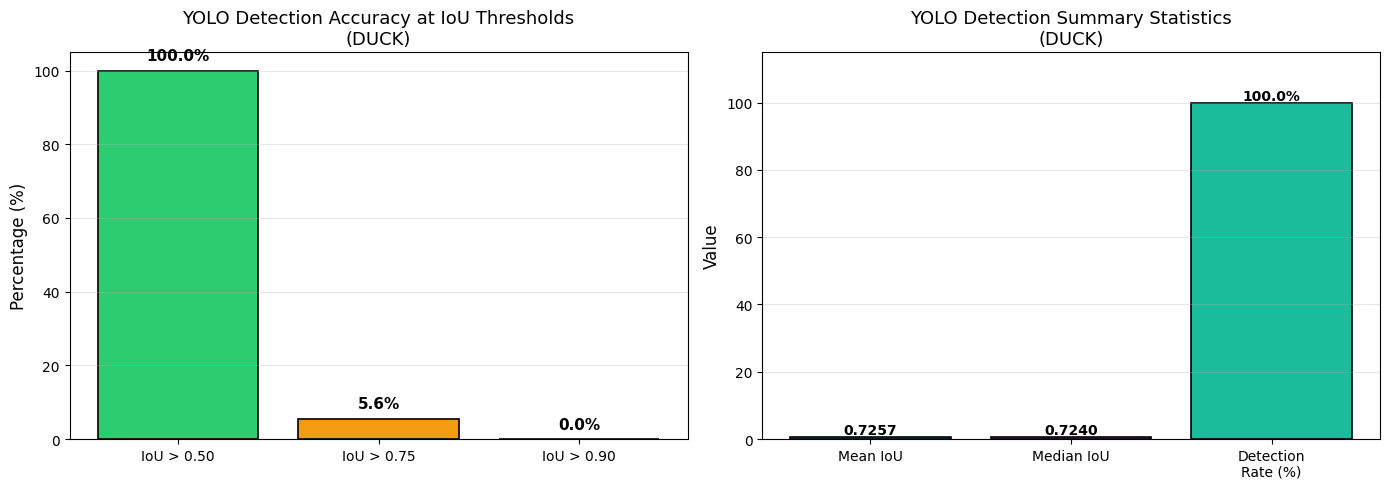


[OK] YOLO detection quality assessment complete


In [4]:
# ==============================================================================
# YOLO DETECTION IoU EVALUATION
# ==============================================================================
# Standalone YOLO evaluation - independent of pose estimation models

YOLO_EVAL_OBJECT = OBJECT_NAME  # Object to evaluate YOLO on

print("\n" + "=" * 60)
print(f"YOLO Detection IoU Evaluation on {YOLO_EVAL_OBJECT.upper()}")
print("=" * 60 + "\n")

# Create dataset for YOLO evaluation (RGBD mode to get bbox_gt and yolo_detected)
yolo_eval_dataset = LineMODDataset(
    root_dir=DATA_ROOT,
    object_name=YOLO_EVAL_OBJECT,
    split='test',
    mode='rgbd',
    num_points=256,  # Minimal points, we only need bboxes
    yolo_model_path=cfg_inference.YOLO_PATH,
    yolo_padding_pct=0.1
)

yolo_eval_loader = DataLoader(
    yolo_eval_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    collate_fn=rgbd_collate_fn
)

print(f"Test dataset: {len(yolo_eval_dataset)} samples")
print(f"YOLO model: {cfg_inference.YOLO_PATH}")

# Compute YOLO IoU statistics
print("\nComputing YOLO IoU statistics...")
yolo_iou_results = evaluate_yolo_iou(yolo_eval_loader, device)

# Print detailed report
print_yolo_iou_report(yolo_iou_results, YOLO_EVAL_OBJECT)

# Plot only if we have real detections
if yolo_iou_results['num_detected'] > 0 and yolo_iou_results['iou_mean'] > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left plot: IoU accuracy at different thresholds
    iou_thresholds = ['IoU > 0.50', 'IoU > 0.75', 'IoU > 0.90']
    iou_values = [yolo_iou_results['iou_50'], yolo_iou_results['iou_75'], yolo_iou_results['iou_90']]
    colors = ['#2ecc71', '#f39c12', '#e74c3c']
    
    bars = axes[0].bar(iou_thresholds, iou_values, color=colors, edgecolor='black', linewidth=1.2)
    axes[0].set_ylabel('Percentage (%)', fontsize=12)
    axes[0].set_title(f'YOLO Detection Accuracy at IoU Thresholds\n({YOLO_EVAL_OBJECT.upper()})', fontsize=13)
    axes[0].set_ylim(0, 105)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, val in zip(bars, iou_values):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                    f'{val:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Right plot: Summary statistics
    stats_labels = ['Mean IoU', 'Median IoU', 'Detection\nRate (%)']
    stats_values = [yolo_iou_results['iou_mean'], yolo_iou_results['iou_median'], 
                   yolo_iou_results['detection_rate']]
    colors_stats = ['#3498db', '#9b59b6', '#1abc9c']
    
    bars2 = axes[1].bar(stats_labels, stats_values, color=colors_stats, edgecolor='black', linewidth=1.2)
    axes[1].set_ylabel('Value', fontsize=12)
    axes[1].set_title(f'YOLO Detection Summary Statistics\n({YOLO_EVAL_OBJECT.upper()})', fontsize=13)
    axes[1].set_ylim(0, max(max(stats_values) * 1.15, 1.0))
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, val, label in zip(bars2, stats_values, stats_labels):
        fmt = f'{val:.1f}%' if 'Rate' in label else f'{val:.4f}'
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                    fmt, ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n[OK] YOLO detection quality assessment complete")
elif yolo_iou_results['num_detected'] == 0:
    print("\n" + "=" * 60)
    print("WARNING: YOLO MODEL NOT DETECTING OBJECTS")
    print("=" * 60)
    print("\nThe fine-tuned YOLO model is not detecting any objects.")
    print("Possible causes:")
    print("  1. YOLO model was not properly trained for this object")
    print("  2. Confidence threshold too high")
    print("  3. Class mapping issue between training and inference")
    print("\nThe pipeline is using GT bbox fallback for pose estimation,")
    print("which means pose estimation results are still valid.")
    print("=" * 60)
else:
    print("WARNING: Low detection rate - YOLO may need retraining.")

## RGB Pipeline Evaluation

In [5]:
if EVAL_TYPE == 'rgb':
    # ==========================================================================
    # RGB PIPELINE EVALUATION
    # ==========================================================================
    # The RGB model predicts BOTH rotation AND translation
    # Input: RGB crop + Pinhole translation estimate
    # Output: Quaternion rotation + 3D translation
    
    checkpoint_path = os.path.join(project_root, cfg_rgb.SAVE_DIR, OBJECT_NAME, 'best_model.pth')
    
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint not found: {checkpoint_path}")
        print("Run training first with: python scripts/master_pipeline.py --object", OBJECT_NAME)
    else:
        print("\n" + "=" * 60)
        print(f"Evaluating RGB Pipeline on {OBJECT_NAME.upper()}")
        print("=" * 60)
        
        # Load model points for ADD metric
        from rgb_pipeline.config import LINEMOD_ID_MAP
        name_to_id = {v: k for k, v in LINEMOD_ID_MAP.items()}
        obj_id_int = name_to_id.get(OBJECT_NAME, 1)
        ply_path = os.path.join(DATA_ROOT, 'models', f'obj_{obj_id_int:02d}.ply')
        
        model_points = load_ply_vertices(ply_path)
        if model_points is not None:
            print(f"Loaded {len(model_points)} model points from {ply_path}")
        else:
            print(f"Warning: Model points not found, ADD metric disabled")
        
        # Create test dataset using unified loader
        test_dataset = LineMODDataset(
            root_dir=DATA_ROOT,
            object_name=OBJECT_NAME,
            split='test',
            mode='rgb',  # RGB mode
            yolo_model_path=cfg_inference.YOLO_PATH,
            yolo_padding_pct=0.1,
            rgb_size=cfg_rgb.INPUT_SIZE[0]
        )
        
        test_loader = DataLoader(
            test_dataset,
            batch_size=cfg_rgb.BATCH_SIZE,
            shuffle=False,
            num_workers=0,
            collate_fn=linemod_collate_fn
        )
        
        print(f"Test dataset: {len(test_dataset)} samples")
        
        # Load model
        model = RGBPoseEstimator(backbone=cfg_rgb.BACKBONE, pretrained=False)
        model.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only=False))
        model.to(device)
        model.eval()
        
        print(f"Model loaded: {checkpoint_path}")
        print(f"Parameters: {model.get_num_parameters():,}")
        
        # Run evaluation
        print("\nRunning evaluation...")
        eval_results = evaluate_rgb_model(
            model=model,
            dataloader=test_loader,
            device=device,
            object_name=OBJECT_NAME,
            model_points=model_points
        )
        
        # Print results
        print_rgb_evaluation_report(eval_results, OBJECT_NAME)


Evaluating RGB Pipeline on DUCK
Loaded 7912 model points from /home/ale/Documents/university/polito/aml/6D-Pose-Estimation-RGBD/data/Linemod_preprocessed/models/obj_09.ply
LineMODDataset (rgb): duck/test - 251 frames
Test dataset: 251 samples
Model loaded: /home/ale/Documents/university/polito/aml/6D-Pose-Estimation-RGBD/trained_checkpoints/duck/best_model.pth
Parameters: 24,858,759

Running evaluation...

RGB EVALUATION RESULTS - DUCK

ROTATION ERROR
   Mean:   5.01 deg
   Median: 4.60 deg
   Std:    2.83 deg

TRANSLATION ERROR
   Mean:   12.09 cm
   Median: 11.47 cm
   Std:    5.50 cm

ACCURACY
   < 5 deg:  58.2%
   < 10 deg: 93.2%
   < 5cm:    6.0%
   < 10cm:   39.8%

ADD METRIC
   Mean ADD:     0.1212 m
   Success Rate: 39.0%



## RGBD Pipeline Evaluation

In [6]:
if EVAL_TYPE == 'rgbd':
    # ==========================================================================
    # RGBD PIPELINE EVALUATION
    # ==========================================================================
    # IMPORTANT: For residual_learning model, we MUST compute proper geometric
    # anchors (T_geo) using bbox, depth, and intrinsics. Using point cloud
    # centroid causes ~4cm error!
    
    checkpoint_path = os.path.join(
        project_root,
        'trained_checkpoints_rgbd',
        MODEL_NAME,
        OBJECT_NAME,
        'best_model.pth'
    )
    
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint not found: {checkpoint_path}")
        print("Run training first with: python scripts/master_pipeline.py --pipeline rgbd --object", OBJECT_NAME)
    else:
        print("\n" + "=" * 60)
        print(f"Evaluating {MODEL_NAME.upper()} on {OBJECT_NAME.upper()}")
        print("=" * 60)
        
        # Object index mapping
        obj_map = {
            'ape': 0, 'benchvise': 1, 'camera': 2, 'can': 3, 'cat': 4,
            'driller': 5, 'duck': 6, 'eggbox': 7, 'glue': 8,
            'holepuncher': 9, 'iron': 10, 'lamp': 11, 'phone': 12
        }
        obj_idx = obj_map.get(OBJECT_NAME.lower(), 0)
        
        # Model kwargs
        num_points = 1024
        model_kwargs = {'num_points': num_points, 'num_obj': 13}
        if 'iterative' in MODEL_NAME:
            model_kwargs['num_iter'] = 2
        if MODEL_NAME in ['pvn3d', 'ffb6d']:
            model_kwargs['num_kp'] = 8
        
        # Create model
        model = create_model(MODEL_NAME, **model_kwargs)
        
        # Load checkpoint (handle both formats)
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            state_dict = checkpoint['model_state_dict']
        else:
            state_dict = checkpoint
        
        # Handle key prefix mismatch
        model_keys = set(model.state_dict().keys())
        sample_model_key = next(iter(model_keys))
        sample_ckpt_key = next(iter(state_dict.keys()))
        
        if sample_model_key.startswith('network.') and not sample_ckpt_key.startswith('network.'):
            state_dict = {f'network.{k}': v for k, v in state_dict.items()}
        
        model.load_state_dict(state_dict)
        model.to(device)
        model.eval()
        
        print(f"Model loaded: {checkpoint_path}")
        
        # Create test dataset using unified loader (RGBD mode)
        test_dataset = LineMODDataset(
            root_dir=DATA_ROOT,
            object_name=OBJECT_NAME,
            split='test',
            mode='rgbd',
            num_points=num_points,
            yolo_model_path=cfg_inference.YOLO_PATH,
            yolo_padding_pct=0.1
        )
        
        test_loader = DataLoader(
            test_dataset,
            batch_size=8,
            shuffle=False,
            num_workers=NUM_WORKERS,
            collate_fn=rgbd_collate_fn
        )
        
        print(f"Test dataset: {len(test_dataset)} samples")
        
        # Run evaluation with proper model_name for geometric anchor handling
        print("\nRunning evaluation...")
        eval_results = evaluate_rgbd_model(model, test_loader, device, obj_idx, model_name=MODEL_NAME)
        
        # Print results
        print_rgbd_evaluation_report(eval_results, MODEL_NAME, OBJECT_NAME)

## Model Comparison (RGBD)


Comparing all RGBD models on DUCK

LineMODDataset (rgbd): duck/test - 251 frames
Test dataset: 251 samples

  residual_learning: Rot=4.54 deg, Trans=0.35 cm
  densefusion_iterative: Rot=10.53 deg, Trans=1.00 cm
  pvn3d: Rot=6.17 deg, Trans=1.66 cm
  ffb6d: Rot=5.05 deg, Trans=3.46 cm

COMPARISON SUMMARY
Model                     Rot (deg)    Trans (cm)   <5 deg     <5cm      
--------------------------------------------------------------------------------
residual_learning         4.54         0.35         71.3       100.0     
densefusion_iterative     10.53        1.00         19.1       99.2      
pvn3d                     6.17         1.66         39.0       99.2      
ffb6d                     5.05         3.46         58.2       80.9      

BEST MODEL DETAILED STATISTICS: RESIDUAL_LEARNING

ROTATION ERROR
   Mean:   4.54 deg
   Median: 3.95 deg

TRANSLATION ERROR
   Mean:   0.35 cm
   Median: 0.32 cm

ACCURACY
   < 5 deg:  71.3%
   < 10 deg: 95.6%
   < 5cm:    100.0%



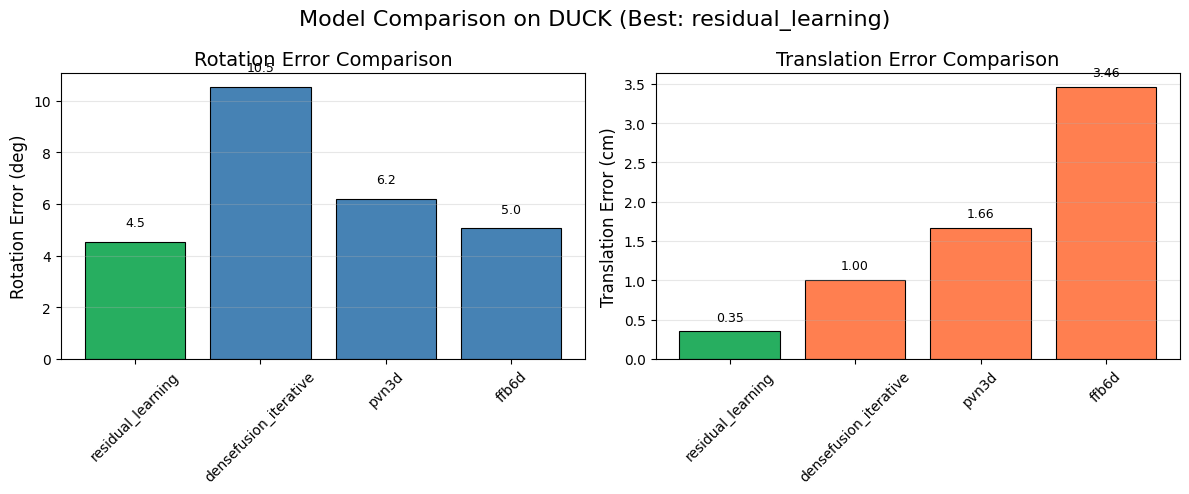

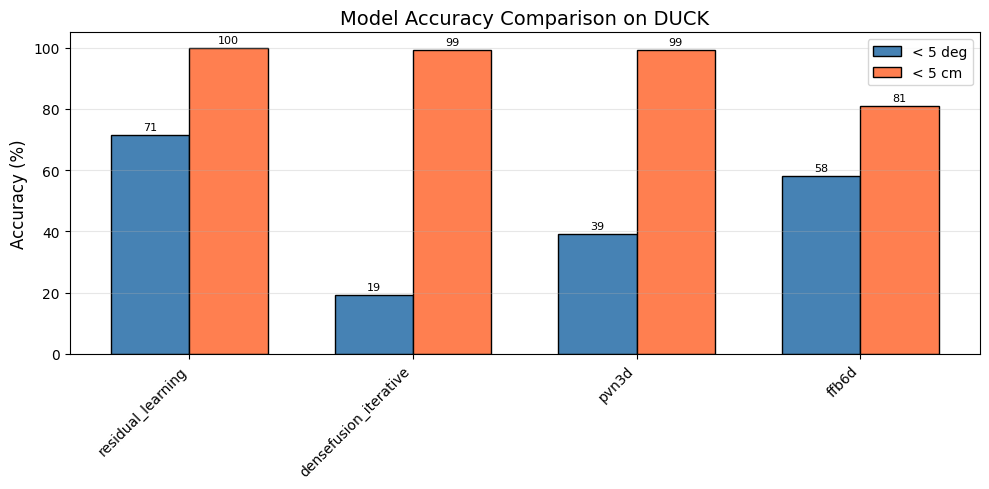

In [7]:
# ==============================================================================
# MODEL COMPARISON (RGBD)
# ==============================================================================

OBJECT_NAME_COMPARE = OBJECT_NAME

print("\n" + "=" * 60)
print(f"Comparing all RGBD models on {OBJECT_NAME_COMPARE.upper()}")
print("=" * 60 + "\n")

obj_map = {
    'ape': 0, 'benchvise': 1, 'camera': 2, 'can': 3, 'cat': 4,
    'driller': 5, 'duck': 6, 'eggbox': 7, 'glue': 8,
    'holepuncher': 9, 'iron': 10, 'lamp': 11, 'phone': 12
}
obj_idx = obj_map.get(OBJECT_NAME_COMPARE.lower(), 0)

# Create test dataset (RGBD mode)
test_dataset = LineMODDataset(
    root_dir=DATA_ROOT,
    object_name=OBJECT_NAME_COMPARE,
    split='test',
    mode='rgbd',
    num_points=1024,
    yolo_model_path=cfg_inference.YOLO_PATH,
    yolo_padding_pct=0.1
)

test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=0,  # Avoid multiprocessing issues
    collate_fn=rgbd_collate_fn
)

print(f"Test dataset: {len(test_dataset)} samples\n")

all_results = {}

for model_name in list_models():
    checkpoint_path = os.path.join(
        project_root,
        'trained_checkpoints_rgbd',
        model_name,
        OBJECT_NAME_COMPARE,
        'best_model.pth'
    )
    
    if not os.path.exists(checkpoint_path):
        print(f"  {model_name}: checkpoint not found, skipping")
        continue
    
    # Model kwargs
    model_kwargs = {'num_points': 1024, 'num_obj': 13}
    if 'iterative' in model_name:
        model_kwargs['num_iter'] = 2
    if model_name in ['pvn3d', 'ffb6d']:
        model_kwargs['num_kp'] = 8
    
    # Create and load model
    model = create_model(model_name, **model_kwargs)
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint
    
    # Handle key prefix mismatch
    model_keys = set(model.state_dict().keys())
    sample_model_key = next(iter(model_keys))
    sample_ckpt_key = next(iter(state_dict.keys()))
    
    if sample_model_key.startswith('network.') and not sample_ckpt_key.startswith('network.'):
        state_dict = {f'network.{k}': v for k, v in state_dict.items()}
    
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    
    # Evaluate with proper model_name for geometric anchor handling
    results = evaluate_rgbd_model(model, test_loader, device, obj_idx, model_name=model_name)
    all_results[model_name] = results
    
    print(f"  {model_name}: Rot={results['rot_err_mean']:.2f} deg, Trans={results['trans_err_mean']:.2f} cm")

# Summary table and plots
if all_results:
    print("\n" + "=" * 80)
    print("COMPARISON SUMMARY")
    print("=" * 80)
    print(f"{'Model':<25} {'Rot (deg)':<12} {'Trans (cm)':<12} {'<5 deg':<10} {'<5cm':<10}")
    print("-" * 80)
    for name, res in all_results.items():
        print(f"{name:<25} {res['rot_err_mean']:<12.2f} {res['trans_err_mean']:<12.2f} "
              f"{res['acc_5deg']:<10.1f} {res['acc_5cm']:<10.1f}")
    
    # Find the best model (lowest combined error)
    # Criteria: weighted sum of normalized rotation and translation error
    best_model = min(all_results.keys(), 
                     key=lambda m: all_results[m]['rot_err_mean'] + all_results[m]['trans_err_mean'])
    best_results = all_results[best_model]
    
    # Print detailed statistics for the best model (like RGB)
    print("\n" + "=" * 60)
    print(f"BEST MODEL DETAILED STATISTICS: {best_model.upper()}")
    print("=" * 60)
    
    print("\nROTATION ERROR")
    print(f"   Mean:   {best_results['rot_err_mean']:.2f} deg")
    print(f"   Median: {best_results['rot_err_median']:.2f} deg")
    
    print("\nTRANSLATION ERROR")
    print(f"   Mean:   {best_results['trans_err_mean']:.2f} cm")
    print(f"   Median: {best_results['trans_err_median']:.2f} cm")
    
    print("\nACCURACY")
    print(f"   < 5 deg:  {best_results['acc_5deg']:.1f}%")
    print(f"   < 10 deg: {best_results['acc_10deg']:.1f}%")
    print(f"   < 5cm:    {best_results['acc_5cm']:.1f}%")
    
    print("\n" + "=" * 60)
    
    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    models = list(all_results.keys())
    rot_errors = [all_results[m]['rot_err_mean'] for m in models]
    trans_errors = [all_results[m]['trans_err_mean'] for m in models]
    
    # Highlight best model
    colors_rot = ['#27ae60' if m == best_model else 'steelblue' for m in models]
    colors_trans = ['#27ae60' if m == best_model else 'coral' for m in models]
    
    bars1 = axes[0].bar(models, rot_errors, color=colors_rot, edgecolor='black', linewidth=0.8)
    axes[0].set_ylabel('Rotation Error (deg)', fontsize=12)
    axes[0].set_title('Rotation Error Comparison', fontsize=14)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, val in zip(bars1, rot_errors):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    f'{val:.1f}', ha='center', va='bottom', fontsize=9)
    
    bars2 = axes[1].bar(models, trans_errors, color=colors_trans, edgecolor='black', linewidth=0.8)
    axes[1].set_ylabel('Translation Error (cm)', fontsize=12)
    axes[1].set_title('Translation Error Comparison', fontsize=14)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, val in zip(bars2, trans_errors):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                    f'{val:.2f}', ha='center', va='bottom', fontsize=9)
    
    fig.suptitle(f'Model Comparison on {OBJECT_NAME_COMPARE.upper()} (Best: {best_model})', fontsize=16)
    fig.tight_layout()
    plt.show()
    
    # Additional accuracy comparison plot
    fig2, ax2 = plt.subplots(1, 1, figsize=(10, 5))
    
    x = np.arange(len(models))
    width = 0.35
    
    acc_5deg = [all_results[m]['acc_5deg'] for m in models]
    acc_5cm = [all_results[m]['acc_5cm'] for m in models]
    
    bars_deg = ax2.bar(x - width/2, acc_5deg, width, label='< 5 deg', color='steelblue', edgecolor='black')
    bars_cm = ax2.bar(x + width/2, acc_5cm, width, label='< 5 cm', color='coral', edgecolor='black')
    
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title(f'Model Accuracy Comparison on {OBJECT_NAME_COMPARE.upper()}', fontsize=14)
    ax2.set_xticks(x)
    ax2.set_xticklabels(models, rotation=45, ha='right')
    ax2.legend()
    ax2.set_ylim(0, 105)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar in bars_deg:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{bar.get_height():.0f}', ha='center', va='bottom', fontsize=8)
    for bar in bars_cm:
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{bar.get_height():.0f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Warning: No trained RGBD models found. Train models first.")